In [46]:
from asyncio import get_event_loop
from websockets import serve
from matplotlib import pyplot as plt
from matplotlib import patches
from skimage import io, transform
from pylibdmtx.pylibdmtx import decode
from multiprocessing import Pool
from io import BytesIO, StringIO
from json import dumps, loads, load
from uuid import uuid4
from math import cos, sin, pi
import base64
from glob import glob
%matplotlib inline

In [102]:
def decode_thread(pp_more):
    if pp_more['well'].shape[0] > 0 and pp_more['well'].shape[1] > 0:
        res = decode(pp_more['well'], max_count=1)
        if res:
            return {**pp_more['pp'], 'barcode': res[0].data.decode()}
        # second try
        res = decode(pp_more['well'], threshold=100, timeout=1000, max_count=1)
        if res:
            return {**pp_more['pp'], 'barcode': res[0].data.decode()}
    return {**pp_more['pp'], 'barcode': "failed"}


def map_wells(col, row, orientation):
    if orientation == 'landscape':  # "normal". A1 is top left
        return f"{['A','B','C','D','E','F','G','H'][row]}{col+1}"
    else:  # rotated 90 degrees right
        return f"{['H','G','F','E','D','C','B','A'][col]}{row+1}"


def analyze_image(image, pps):
    wells = [{'pp':pp, 'well': image[pp['minY']:pp['maxY'], pp['minX']:pp['maxX']]} for pp in pps]
    with Pool(8) as p:
        rar = p.map(decode_thread, wells)
    return rar
    
def read_dem_wells(all_data: dict):
    grid = all_data['grid']
    iscale = all_data['scale']
    images = all_data['images']
    image_zero = io.imread(BytesIO(base64.decodebytes(images[0]['src'].split(',')[1].encode())))
    
    scale = image_zero.shape[1] / iscale
    if grid['width'] > grid['height']:
        grid_size = (grid['width'] / 12) * scale
        orientation = "landscape"
        no_rows = 8
        no_cols = 12
    else:
        grid_size = (grid['height'] / 12) * scale
        orientation = "portrait"
        no_rows = 12
        no_cols = 8
    width = grid_size * grid['scaleX']
    height = grid_size * grid['scaleY']
    ori_x = grid['left'] * scale
    ori_y = grid['top'] * scale
    angle = (grid['angle'] / 360) * 2 * pi
    pps = []
    for row in range(no_rows):
        for col in range(no_cols):
            dx1 = ori_x + width * col * cos(angle) - height * row * sin(angle)
            dx2 = ori_x + width * col * cos(angle) - height * (row + 1) * sin(angle)
            dx3 = ori_x + width * (col + 1) * cos(angle) - height * (row + 1) * sin(angle)
            dx4 = ori_x + width * (col + 1) * cos(angle) - height * row * sin(angle)
            dxs = [dx1, dx2, dx3, dx4]
            dy1 = ori_y + width * col * sin(angle) + height * row * cos(angle)
            dy2 = ori_y + width * col * sin(angle) + height * (row + 1) * cos(angle)
            dy3 = ori_y + width * (col + 1) * sin(angle) + height * (row + 1) * cos(angle)
            dy4 = ori_y + width * (col + 1) * sin(angle) + height * row * cos(angle)
            dys = [dy1, dy2, dy3, dy4]
            
            pps.append({'col':col, 'row': row, 'minY': int(min(dys)), 'maxY': int(max(dys)), 'minX': int(min(dxs)), 'maxX': int(max(dxs)), 'x0': dx1, 'y0':dy1})


    results = [analyze_image(io.imread(BytesIO(base64.decodebytes(image['src'].split(',')[1].encode()))), pps) for image in images]
    
    # analyze results
    rar = [] #list of well objects with {'row', 'col', 'barcode', 'x0', 'y0'}
    for well_no in range(no_rows*no_cols):
        #check that its the same well
        if len(set([results[i][well_no]['col'] for i in range(len(results))]))==1 and len(set([results[i][well_no]['row'] for i in range(len(results))]))==1:
            barcodes = set([results[i][well_no]['barcode'] for i in range(len(results)) if results[i][well_no]['barcode'] != 'failed'])
            if len(barcodes) == 1:
                print("sucess")
                rar.append({**results[0][well_no], 'barcode':barcodes.pop()})
            elif len(barcodes) == 0:
                rar.append({**results[0][well_no], 'barcode':'failed'})
            else:
                rar.append({**results[0][well_no], 'barcode':'multi_barcodes'})
        else:
            print("error...not same well?")
    
    # draw result consensus
    fig, ax = plt.subplots(1, figsize=(10, 20))
    ax.imshow(image_zero)
    rect = patches.Rectangle((grid['left'] * scale, grid['top'] * scale), width=grid['width'] * grid['scaleX'] * scale,
                                                     height=grid['height'] * grid['scaleY'] * scale, angle=grid['angle'], linewidth=1,
                                                     edgecolor='r', facecolor='none')
    ar_pa = patches.Arrow(grid['left'] * scale, grid['top'] * scale, cos(((grid['angle'] - 90) / 360) * (2 * pi)) * 50,
                                                sin(((grid['angle'] - 90) / 360) * (2 * pi)) * 50, color='green', width=10)
    ax.add_patch(rect)
    ax.add_patch(ar_pa)
    
    for irar in rar:
        if irar['barcode'] == 'failed':
            color = 'red'
            lw = 3
        elif irar['barcode'] == 'multi_barcodes':
            color = 'blue'
            lw = 3
        else:
            color = 'green'
            lw = 1
        mrect = patches.Rectangle((irar['x0'], irar['y0']), width=width, height=height, angle=grid['angle'], linewidth=lw, edgecolor=color,facecolor='none')
        ax.add_patch(mrect)

    f = BytesIO()
    ax.axis('off')
    fig.savefig(f, format='png', bbox_inches='tight')
    return [{'loc': map_wells(entry['col'], entry['row'], orientation), 'barcode': entry['barcode']} for entry in rar], f.getvalue()

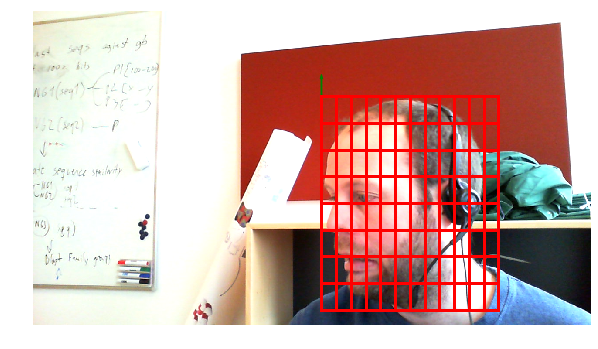

In [103]:
rar, im = read_dem_wells(load(open(glob("*.json")[0], 'r')))

In [104]:
import pandas as pd
df = pd.DataFrame(rar)

In [106]:
df

,barcode,loc
0,failed,A1
1,failed,A2
2,failed,A3
3,failed,A4
4,failed,A5
5,failed,A6
6,failed,A7
7,failed,A8
8,failed,A9
9,failed,A10


In [59]:
type(a)

dict